# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import logging
import os

log_path = os.getcwd()+"/log"
model_dir= os.getcwd()+"/model_dir"
    
os.makedirs(model_dir, exist_ok=True)

logging.basicConfig(fileName=log_path+"/training_metrics.log")
logger = logging.getLogger('TennisTraining')
hdlr = logging.FileHandler(log_path+"/training_metrics.log")
logger.addHandler(hdlr)
logger.setLevel(logging.INFO)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [69]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


When finished, you can close the environment.

### 4. Training using a multi-agents DDPG algorithm

Now it's time to train the agents to solve the environment!  When training the environment, we set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

First let's set up the various variables and import the required modules.

In [6]:
from buffer import ReplayBuffer
import torch
import numpy as np
from utilities import to_tensor, flatten, transpose_to_nested_list
import progressbar as pb
from collections import deque

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seeding()

# number of training episodes.
number_of_episodes = 4002
episode_length = 500
batchsize = 512

# how many episodes to save policy
save_interval = 100
t = 0
    
# amplitude of OU noise
# this slowly decreases to 0
noise = 2
noise_reduction = 0.998

# how many timesteps before update
timesteps_per_update = 1

# how many update loops for every learning
update_loops = 5

# keep 1000 episodes worth of replay
buffer = ReplayBuffer(int(1000*episode_length))

Then instantiate our Multi-Agent DDPG.

In [7]:
# version with shared networks
from maddpg_v3 import MADDPG_v3

# version with disctinct set of actors and critic networks for each agent
from maddpg import MADDPG

# for the OUNoise
import random

# initialize policy and critic
maddpg = MADDPG(tau = 0.01)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Define the training loop.

In [35]:
def train(number_of_episodes = number_of_episodes, episode_length = episode_length, batchsize = batchsize, noise = noise, noise_reduction = noise_reduction, log = logger, trial = ""):

    # training loop
    # show progressbar
    widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
              pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

    # log scores to test when environment is solved
    scores_deque = deque(maxlen=100)    
    agent0_reward = deque(maxlen=100)
    agent1_reward = deque(maxlen=100)
    
    scores_list = []
    current_episode_score = 0.0
    mean_score_deque = 0.0
    max_score = -np.inf
    max_avg_score = [-np.inf, -np.inf, -np.inf]   # max average score over 100 episodes for agent 1, agent 2, max over both agents
    noise_array = [noise, noise]
    t_noise_change = 0
    actor_losses = [[],[]]
    critic_losses = [[],[]]
    flag_solved = False

    for episode in range(0, number_of_episodes):

        timer.update(episode)

        scores = np.zeros((2))
        all_obs = env.reset(train_mode=True)[brain_name].vector_observations 
        obs, obs_full = all_obs, flatten(all_obs)

        #for calculating rewards for this particular episode - addition of all time steps

        # save info or not
        save_info = ((episode) % save_interval == 0 or episode==number_of_episodes)
        
        if save_info:
            log.info("training parameters: max number of episodes= {}, episode length= {}, batchsize= {}, noise= {}, noise_reduction= {}".format(number_of_episodes, episode_length, batchsize, noise, noise_reduction))

        t = 0
        maddpg.reset_noise()
        
        for episode_t in range(episode_length):

            t +=1

            # only explore for a certain number of episodes by decreasing the noise parameter
            actions = maddpg.act(to_tensor(obs), noise=noise_array)
            
            actions_for_env = torch.stack(actions).detach().cpu().numpy()

            # step forward one frame
            env_info = env.step(actions_for_env)[brain_name]           # send all actions to tne environment
            next_all_obs = env_info.vector_observations                # get next state (for each agent)
            next_obs, next_obs_full = next_all_obs, flatten(next_all_obs)     
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            
            # update update_loops times every timesteps_per_update
            if len(buffer) > batchsize and episode % timesteps_per_update == 0:
                for _ in range(update_loops):
                    for a_i in range(2):
                        samples = buffer.sample(batchsize)
                        [al, cl] = maddpg.update(samples, a_i, log)
                        actor_losses[a_i].append(al)
                        critic_losses[a_i].append(cl)
                maddpg.update_targets() #soft update the target network towards the actual networks

            
            obs = next_obs                               # roll over states to next time step
            
            if np.any(dones):                                  # exit loop if episode finished
                break
            
            # add data to buffer, saving obs as tensors to use them directly in DDPG networks
            transition = (to_tensor(obs),torch.tensor(obs_full, dtype = torch.float).to(device), actions_for_env, rewards, to_tensor(next_obs), torch.tensor(next_obs_full, dtype = torch.float).to(device), dones)
            
            buffer.push(transition)
            
            obs, obs_full = next_obs, next_obs_full
                    
        noise_array[0] *= noise_reduction
        noise_array[1] *= noise_reduction
        t_noise_change += 1

        current_episode_score = np.max(scores)

        agent0_reward.append(scores[0])
        agent1_reward.append(scores[1])
        
        scores_deque.append(current_episode_score)
        scores_list.append(current_episode_score)
        
        mean_score_deque = np.mean(scores_deque)
                
        # update max scores reached
        if current_episode_score > max_score:
            max_score = current_episode_score
        
        if np.mean(agent0_reward) >= max_avg_score[0]:
            max_avg_score[0] = np.mean(agent0_reward)
            
        if np.mean(agent1_reward) >= max_avg_score[1]:
            max_avg_score[1] = np.mean(agent1_reward)
        
        if mean_score_deque >= max_avg_score[2]:
            max_avg_score[2] = mean_score_deque
            
        if episode>=99:
            # slowly decrease the learning rate
            maddpg.adapt_learning_rate(0.999)
            
            # if more exploration is needed for one agent, increase noise for this one
            # up to a maximum noise level which decreases anyway over the episodes to push exploitation
            if t_noise_change >20:
                if 0.5 * max_avg_score[0] > np.mean(agent0_reward):
                    noise_array[0] = min(noise * max(1/np.log(episode), pow(noise_reduction, episode)), noise_array[0] * 2.0)
            
                if 0.5 * max_avg_score[1] > np.mean(agent1_reward):
                    noise_array[1] = min(noise * max(1/np.log(episode), pow(noise_reduction, episode)), noise_array[1] * 2.0)
                
                t_noise_change = 0   # increase noise level only every 20 episodes
        
        # if the past 100 scores is above the 0.5 mark and this is the first time it is seen
        if mean_score_deque > 0.5 and flag_solved == False and episode>=99:
            print('\rProblem solved in {} episodes, average score over past 100 episodes: {:.3f}'.format(episode, mean_score_deque))
            log.info('\rProblem solved in {} episodes, average score over past 100 episodes: {:.3f}'.format(episode, mean_score_deque))
            flag_solved = True
            for i in range(2):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}-{}-solved.pt'.format(episode, trial)))
        
        if episode % 100 == 0 or episode == number_of_episodes-1:
            print('\rEpisode {}\tAverage Score: {:.3f}\tEpisode Score: {:.3f}\tBest Score: {:.3f}\tNoises: {}\tMax Avg Scores: {}'.format(episode, mean_score_deque, current_episode_score, max_score, noise_array, max_avg_score))

        #saving model
        save_dict_list =[]
        if save_info:
            for i in range(2):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}-{}.pt'.format(episode, trial)))
    
    print('\rEpisode {}\tAverage Score: {:.3f}\tEpisode Score: {:.3f}\tBest Score: {:.3f}'.format(episode, mean_score_deque, current_episode_score, max_score))
    return scores_list, actor_losses, critic_losses

This second training loop is similar to the one above except it implements a more straightfoward noise decay, purely linear by a fixed amount after each episode.

In [51]:
def train_v2(number_of_episodes = number_of_episodes, episode_length = episode_length, batchsize = batchsize, noise = noise, noise_reduction = noise_reduction, log = logger, trial = ""):

    # training loop
    # show progressbar
    widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
              pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

    # log scores to test when environment is solved
    scores_deque = deque(maxlen=100)    
    agent0_reward = deque(maxlen=100)
    agent1_reward = deque(maxlen=100)
    
    scores_list = []
    current_episode_score = 0.0
    mean_score_deque = 0.0
    max_score = -np.inf
    max_avg_score = [-np.inf, -np.inf, -np.inf]   # max average score over 100 episodes for agent 1, agent 2, max over both agents
    noise_array = [noise, noise]
    noise_reduction = noise * noise_reduction  # change noise reduction to fixed amount
    actor_losses = [[],[]]
    critic_losses = [[],[]]
    flag_solved = False

    for episode in range(0, number_of_episodes):

        timer.update(episode)

        scores = np.zeros((2))
        all_obs = env.reset(train_mode=True)[brain_name].vector_observations 
        obs, obs_full = all_obs, flatten(all_obs)

        #for calculating rewards for this particular episode - addition of all time steps

        # save info or not
        save_info = ((episode) % save_interval == 0 or episode==number_of_episodes)
        
        if save_info:
            log.info("training parameters: max number of episodes= {}, episode length= {}, batchsize= {}, noise= {}, noise_reduction= {}".format(number_of_episodes, episode_length, batchsize, noise, noise_reduction))

        t = 0
        maddpg.reset_noise()
        
        for episode_t in range(episode_length):

            t +=1

            # only explore for a certain number of episodes by decreasing the noise parameter
            actions = maddpg.act(to_tensor(obs), noise=noise_array)
            
            actions_for_env = torch.stack(actions).detach().cpu().numpy()

            # step forward one frame
            env_info = env.step(actions_for_env)[brain_name]           # send all actions to tne environment
            next_all_obs = env_info.vector_observations                # get next state (for each agent)
            next_obs, next_obs_full = next_all_obs, flatten(next_all_obs)     
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            
            # update update_loops times every timesteps_per_update
            if len(buffer) > batchsize and episode % timesteps_per_update == 0:
                for _ in range(update_loops):
                    for a_i in range(2):
                        samples = buffer.sample(batchsize)
                        [al, cl] = maddpg.update(samples, a_i, log)
                        actor_losses[a_i].append(al)
                        critic_losses[a_i].append(cl)
                maddpg.update_targets() #soft update the target network towards the actual networks

            
            obs = next_obs                               # roll over states to next time step
            
            if np.any(dones):                                  # exit loop if episode finished
                break
            
            # add data to buffer, saving obs as tensors to use them directly in DDPG networks
            transition = (to_tensor(obs),torch.tensor(obs_full, dtype = torch.float).to(device), actions_for_env, rewards, to_tensor(next_obs), torch.tensor(next_obs_full, dtype = torch.float).to(device), dones)
            
            buffer.push(transition)
            
            obs, obs_full = next_obs, next_obs_full
                    
        noise_array[0] = max(0.0, noise_array[0]-noise_reduction)
        noise_array[1] = max(0.0, noise_array[1]-noise_reduction)

        current_episode_score = np.max(scores)

        agent0_reward.append(scores[0])
        agent1_reward.append(scores[1])
        
        scores_deque.append(current_episode_score)
        scores_list.append(current_episode_score)
        
        mean_score_deque = np.mean(scores_deque)
                
        # update max scores reached
        if current_episode_score > max_score:
            max_score = current_episode_score
        
        if np.mean(agent0_reward) >= max_avg_score[0]:
            max_avg_score[0] = np.mean(agent0_reward)
            
        if np.mean(agent1_reward) >= max_avg_score[1]:
            max_avg_score[1] = np.mean(agent1_reward)
        
        if mean_score_deque >= max_avg_score[2]:
            max_avg_score[2] = mean_score_deque
            
        if episode>=99:
            # slowly decrease learning rate
            maddpg.adapt_learning_rate(0.999)
            
        # if the past 100 scores is above the 0.5 mark and this is the first time it is seen or we hit a new high score
        if mean_score_deque > 0.5 and ((flag_solved == False) or (current_episode_score == max_score)) and episode>=99:
            print('\rProblem solved in {} episodes, average score over past 100 episodes: {:.3f}'.format(episode, mean_score_deque))
            log.info('\rProblem solved in {} episodes, average score over past 100 episodes: {:.3f}'.format(episode, mean_score_deque))
            flag_solved = True
            for i in range(2):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}-{}-solved.pt'.format(episode, trial)))
        
        if episode % 1 == 0 or episode == number_of_episodes-1:
            print('\rEpisode {}\tAverage Score: {:.3f}\tEpisode Score: {:.3f}\tBest Score: {:.3f}\tNoises: {}\tMax Avg Scores: {}'.format(episode, mean_score_deque, current_episode_score, max_score, noise_array, max_avg_score))

        #saving model
        save_dict_list =[]
        if save_info:
            for i in range(2):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}-{}.pt'.format(episode, trial)))
    
    print('\rEpisode {}\tAverage Score: {:.3f}\tEpisode Score: {:.3f}\tBest Score: {:.3f}'.format(episode, mean_score_deque, current_episode_score, max_score))
    return scores_list, actor_losses, critic_losses

Launch the training, here with the shared network version from MADDPG_v3.

In [58]:
tau = 0.05

maddpg = MADDPG_v3(tau = tau, discount_factor = 0.99)

update_loops = 1
noise = 0
noise_reduction = 1.0/300.0 # decrease and then stop noise after 300 episodes

trial = "update_every_t_tau-{}-update_loop-{}-noise-{}_new-v3".format(tau, update_loops, noise)

scores_total = []  # will be used to store the scores if the training is launched in multiple parts

In [73]:
number_of_episodes = 20

new_scores_3, actor_losses_3, critic_losses_3 = train_v2(log = logger, trial = trial, noise = noise, noise_reduction = noise_reduction, number_of_episodes = number_of_episodes)

INFO:TennisTraining:training parameters: max number of episodes= 20, episode length= 500, batchsize= 512, noise= 0, noise_reduction= 0.0


Episode 0	Average Score: 0.100	Episode Score: 0.100	Best Score: 0.100	Noises: [0.0, 0.0]	Max Avg Scores: [0.10000000149011612, -0.009999999776482582, 0.10000000149011612]


Episode 1	Average Score: 0.700	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.7000000104308128, 0.6450000097975135, 0.7000000104308128]


Episode 2	Average Score: 0.900	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 3	Average Score: 0.700	Episode Score: 0.100	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 4	Average Score: 0.820	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 5	Average Score: 0.683	Episode Score: 0.000	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 6	Average Score: 0.771	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 7	Average Score: 0.838	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 8	Average Score: 0.756	Episode Score: 0.100	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 9	Average Score: 0.810	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 10	Average Score: 0.755	Episode Score: 0.200	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 11	Average Score: 0.800	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 12	Average Score: 0.738	Episode Score: 0.000	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 13	Average Score: 0.779	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 14	Average Score: 0.727	Episode Score: 0.000	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 15	Average Score: 0.688	Episode Score: 0.100	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 16	Average Score: 0.724	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 17	Average Score: 0.683	Episode Score: 0.000	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]


Episode 18	Average Score: 0.716	Episode Score: 1.300	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]
Episode 19	Average Score: 0.680	Episode Score: 0.000	Best Score: 1.300	Noises: [0.0, 0.0]	Max Avg Scores: [0.9000000134110451, 0.8633333463221788, 0.9000000134110451]
Episode 19	Average Score: 0.680	Episode Score: 0.000	Best Score: 1.300


In [74]:
for s in new_scores_3:
    scores_total.append(s)

The below cell is useful to test multiple hyper parameters in a loop. Beware of the number of episodes as a too large number could lead to a very long loop depending on the number of cases tested.

In [7]:
trial = ""
taus = [0.01, 0.05, 0.001]
episode_per_update_list = [1, 2, 3, 4]
noise_list = [3, 2, 1, 0.5]
scores = []
actor_losses = []
critic_losses = []
number_of_episodes = 501

for tau in taus:
    for episode_per_update in episode_per_update_list:
        for noise in noise_list:
            trial = "tau-{}-update-{}-noise-{}".format(tau, episode_per_update, noise)
            logging.basicConfig(fileName=log_path+"/training_metrics-{}.log".format(trial))
            buffer = ReplayBuffer(int(1000*episode_length))
            maddpg = MADDPG(tau = tau)
            s, a, c = train(number_of_episodes = number_of_episodes, log = logger, trial = trial, noise = noise)
            scores.append(s)
            actor_losses.append(a)
            critic_losses.append(c)

### 5. Display training plot
In the next code cell, the graph of the score reached by the 2 collaborating agents on average at the end of the training and the 100-episodes moving average is shown. This 100-episode moving average is the value against which the environment is considered solved or not.

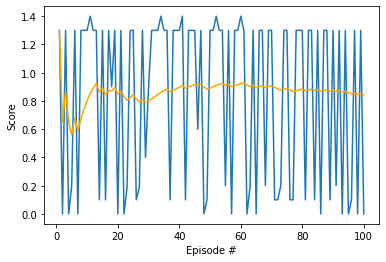

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

score = scores_total
# compute rolling average
rolling_mean = np.copy(score)
ma = 100
    
for i in range(len(rolling_mean)):
    rolling_mean[i] = (float)(np.mean(score[max(0,i-ma):i+1]))
    
# display graph
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score)+1), score)
plt.plot(np.arange(1, len(score)+1), rolling_mean, label='100 episodes moving average', color='orange')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

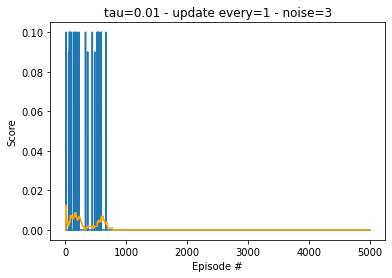

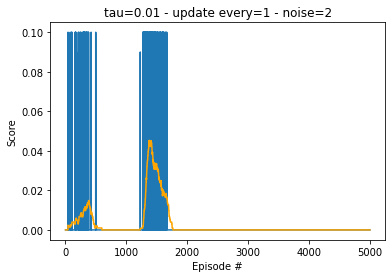

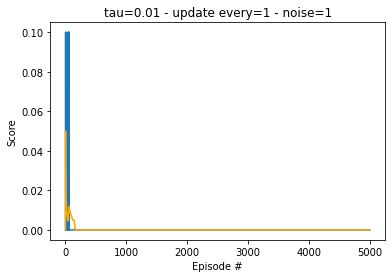

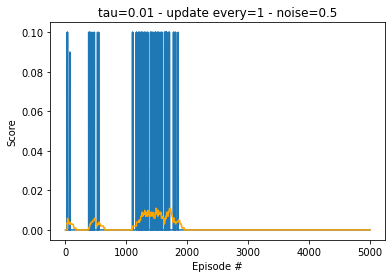

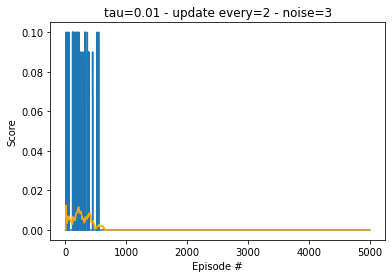

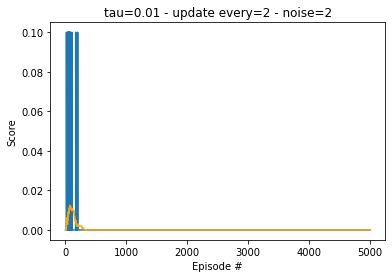

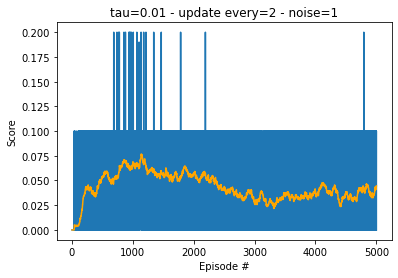

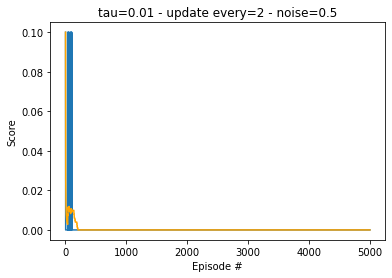

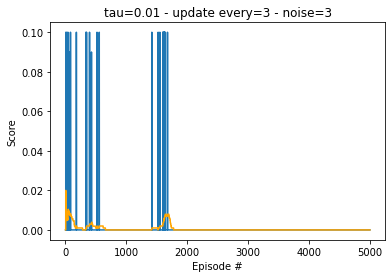

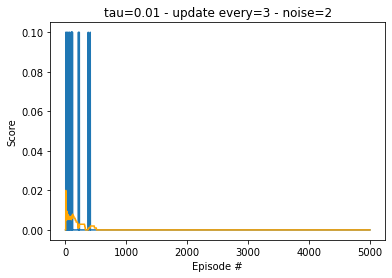

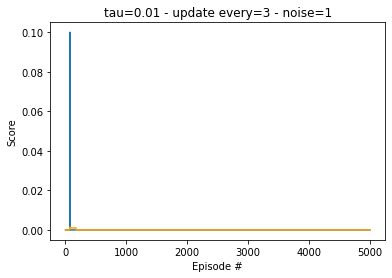

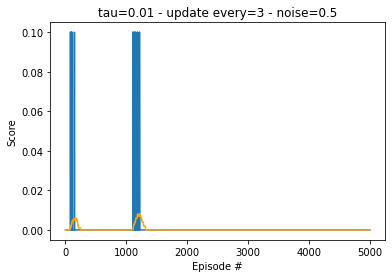

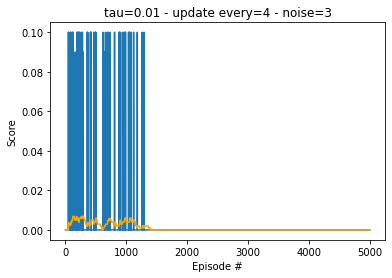

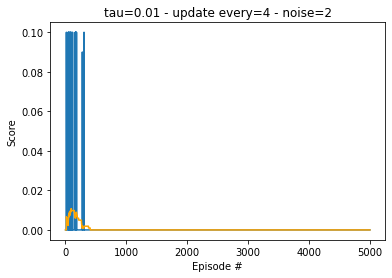

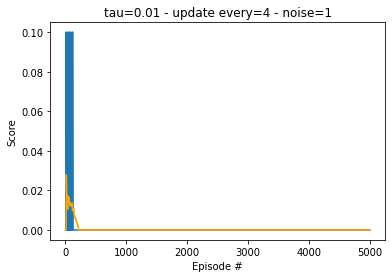

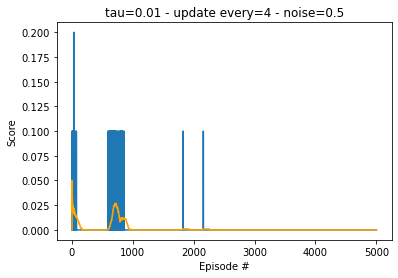

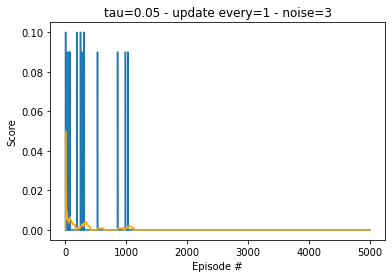

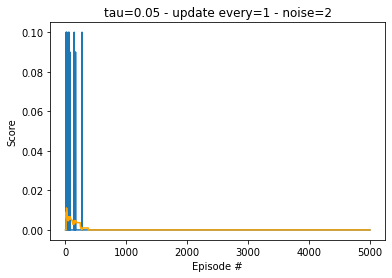

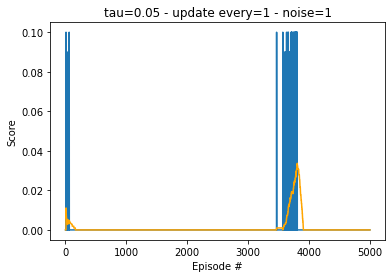

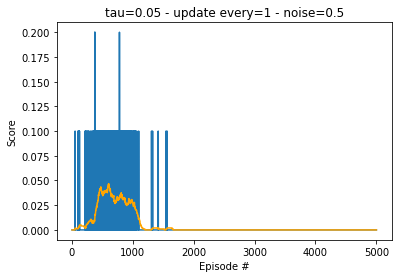

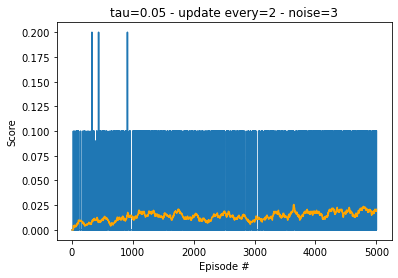

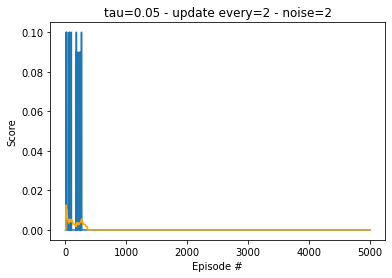

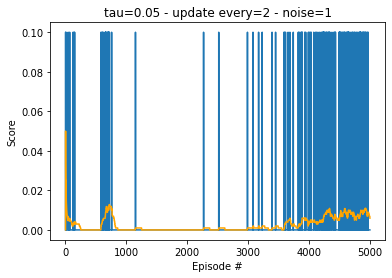

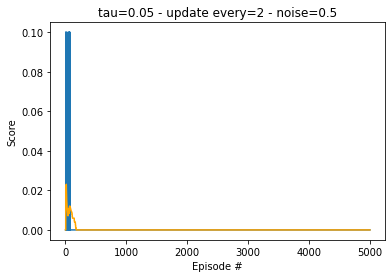

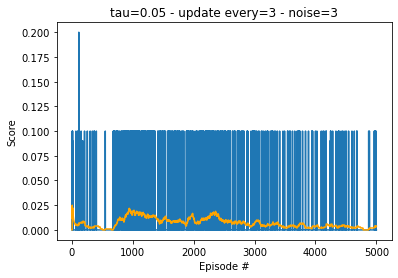

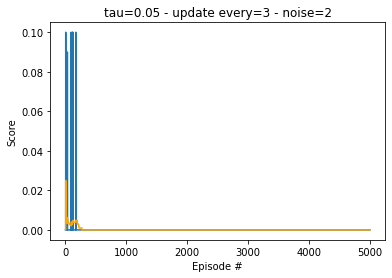

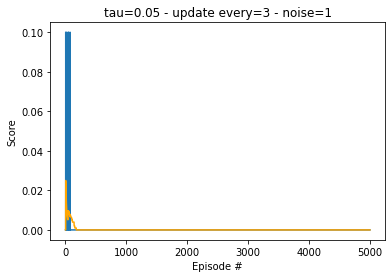

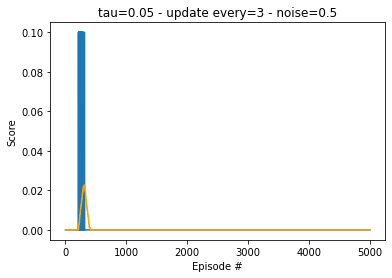

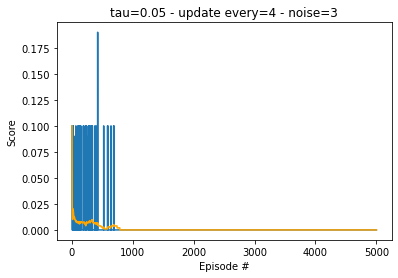

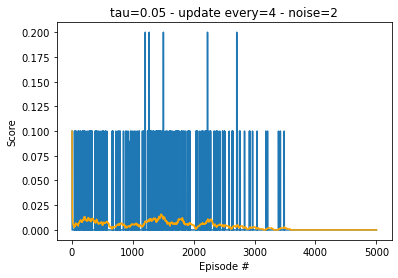

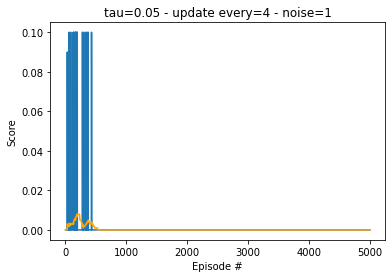

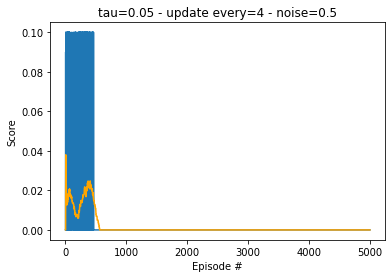

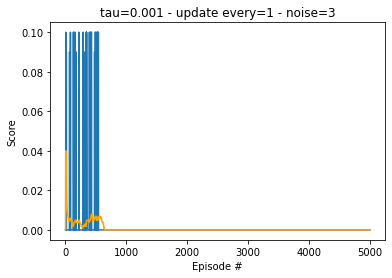

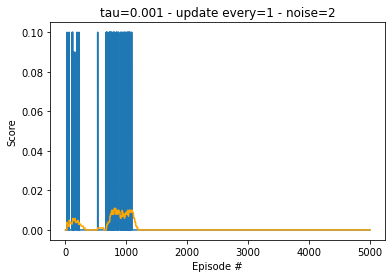

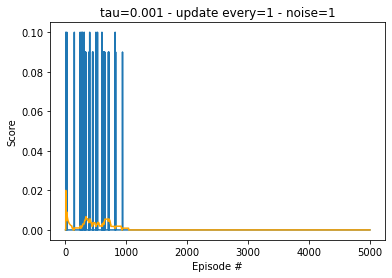

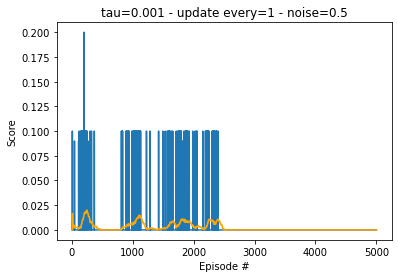

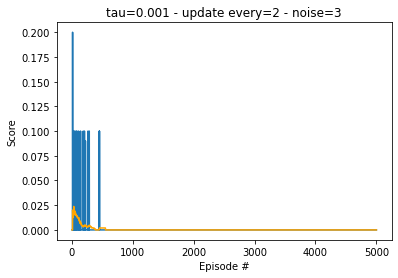

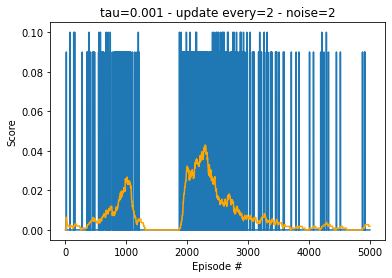

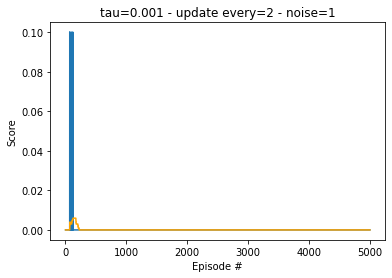

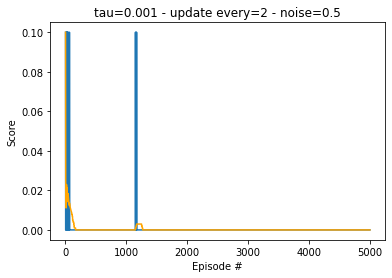

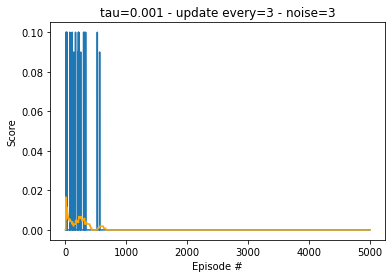

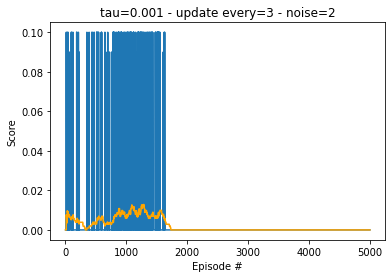

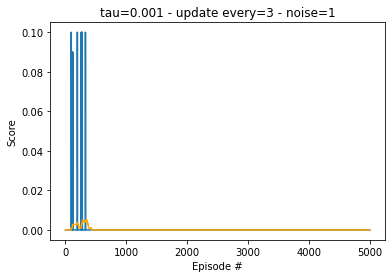

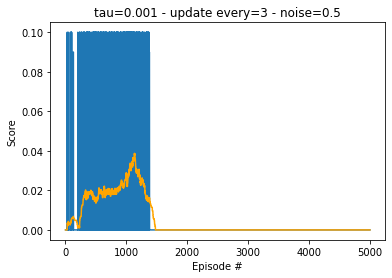

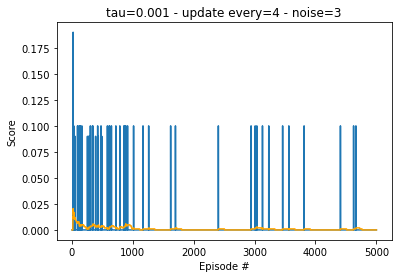

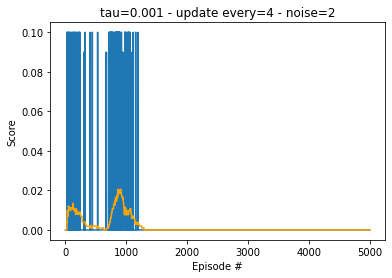

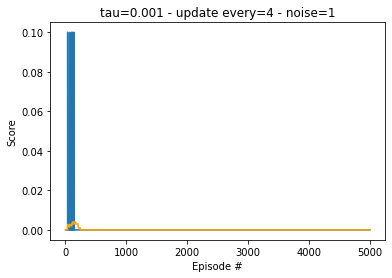

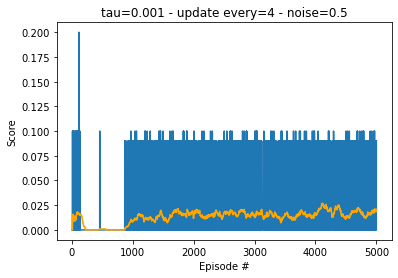

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = []

for tau in taus:
    for episode_per_update in episode_per_update_list:
        for noise in noise_list:
            labels.append("tau={} - update every={} - noise={}".format(tau, episode_per_update, noise))

j = 0
for score in scores:
    # compute rolling average
    rolling_mean = np.copy(score)
    ma = 100
    
    for i in range(len(rolling_mean)):
        rolling_mean[i] = (float)(np.mean(score[max(0,i-ma):i+1]))
    
    # display graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(score)+1), score)
    plt.plot(np.arange(1, len(score)+1), rolling_mean, label='100 episodes moving average', color='orange')
    plt.title(labels[j])
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
    j += 1

### 6. Test a trained agent
In the next code cell, the weights of a trained agent are loaded and then the agent is used in the environment. The score reached should be most of the times above +0.5.


In [11]:
def load_model(main_agent, checkpoint_file):
    """Load current model parameters"""
    checkpoint = torch.load(model_dir + "/" + checkpoint_file)
    i = 0
    for agent in main_agent.maddpg_agent:
        chkpt = checkpoint[i]
        agent.actor.load_state_dict(chkpt["actor_params"])
        agent.actor_optimizer.load_state_dict(chkpt["actor_optim_params"])
        agent.target_actor.load_state_dict(chkpt["actor_params"])
        agent.critic.load_state_dict(chkpt["critic_params"])
        agent.critic_optimizer.load_state_dict(chkpt["critic_optim_params"])
        i += 1

checkpoint_file = "episode-140-update_every_t_tau-0.05-update_loop-1-noise-0_new-v3-solved.pt"

maddpg = MADDPG_v3()
load_model(maddpg, checkpoint_file)

number_of_games = 5

for i in range(number_of_games):

    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)

    while True:
        actions = maddpg.act(to_tensor(states), noise=[0,0])
    
        actions_for_env = torch.stack(actions).detach().cpu().numpy()

        # step forward one frame
        env_info = env.step(actions_for_env)[brain_name]
    
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
        
    print('Total score (max over agents) this episode: {}'.format(np.max(scores)))


Total score (max over agents) this episode: 2.600000038743019
Total score (max over agents) this episode: 0.10000000149011612
Total score (max over agents) this episode: 2.600000038743019
Total score (max over agents) this episode: 0.20000000298023224
Total score (max over agents) this episode: 2.600000038743019


Finally let's close the environment.

In [78]:
env.close()